In [1]:
%load_ext autoreload
%autoreload 2

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns
from torch import optim

# Dataset

In [3]:
from dataset import get_pytorch_datataset, BATCH_SIZE

df_returns_real, dataset, dataloader, N_ASSETS, WINDOW_SIZE = get_pytorch_datataset()

print(f'\nDataset length: {len(dataset)}')
print(f'Number of assets: {N_ASSETS}')
sample_batch = next(iter(dataloader))
assert sample_batch.size() == (BATCH_SIZE, N_ASSETS, WINDOW_SIZE)
print(f'Sample batch: {sample_batch.size()}')

Chosen tickers: ['LKOH', 'SBERP', 'VTBR', 'SBER', 'MOEX']
Length before dropping NaNs: 2603
Length after dropping NaNs: 2577

Dataset length: 2451
Number of assets: 5
Sample batch: torch.Size([256, 5, 126])


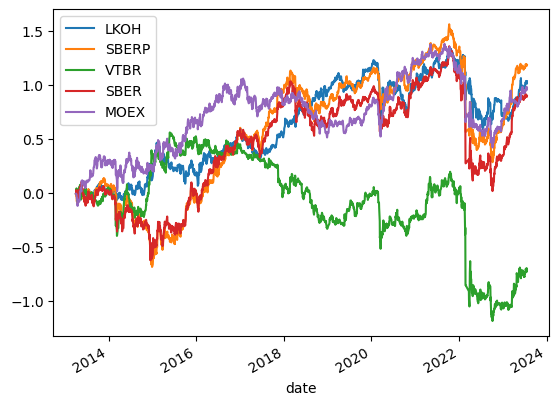

In [4]:
df_returns_real.cumsum().plot()
plt.show()

# GAN


In [5]:
from constants import DEVICE

print(f'Use device: {DEVICE}')

Use device: cuda:0


In [6]:
from gan import Discriminator, Generator

assert Discriminator()(next(iter(dataloader))).size() == (BATCH_SIZE,)
assert Generator()(Generator.get_noise(BATCH_SIZE)).size() == next(iter(dataloader)).size()

## Train

50 epochs train time: 22.2s. Estimated train time: 0.0m
Fake std: [0.01740621 0.01578433 0.02540329 0.02011233 0.0158733 ].
Real std: [0.01934618 0.02170969 0.02256658 0.02320357 0.01871406]
Fake correlation: 0.8735252588104815. Real correlation: 0.9185647795211369


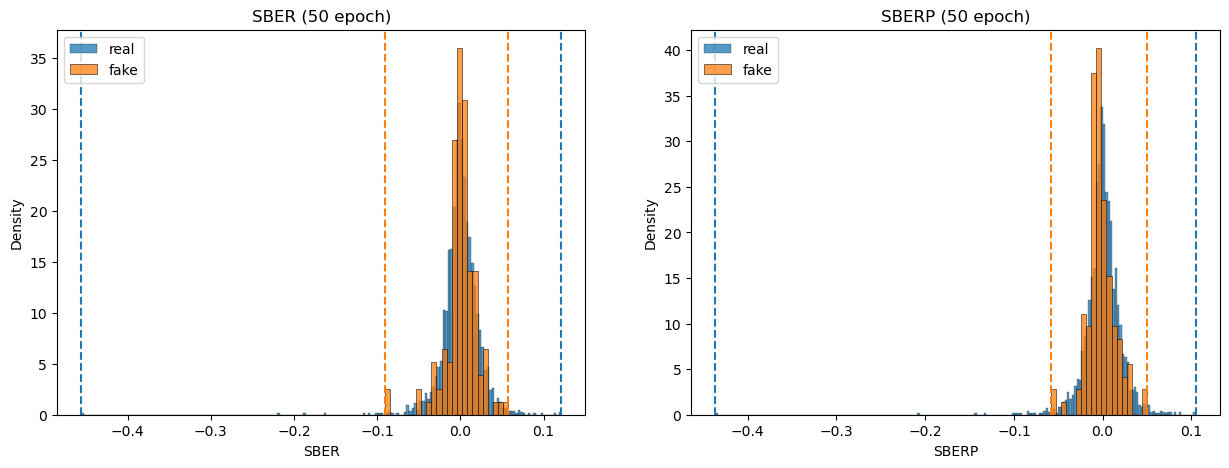

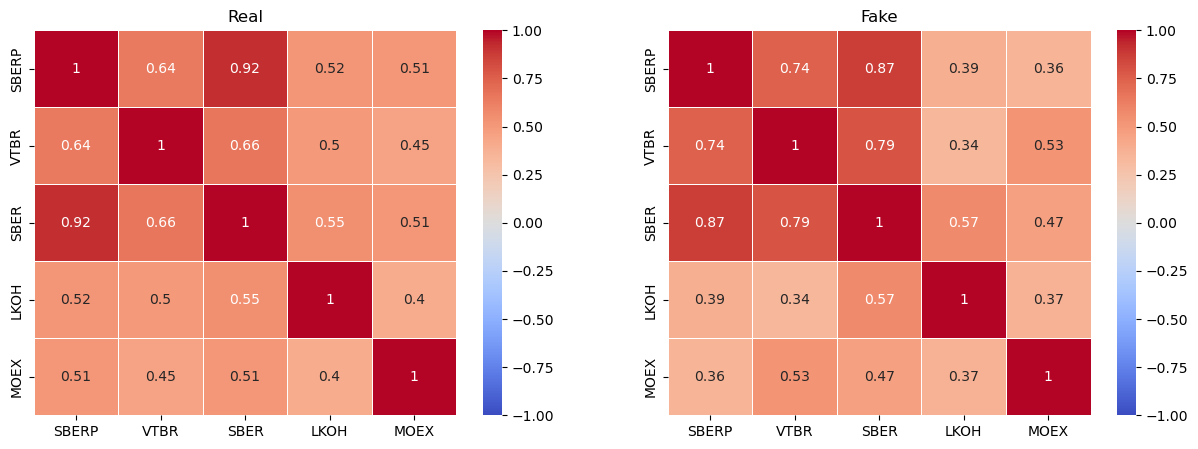

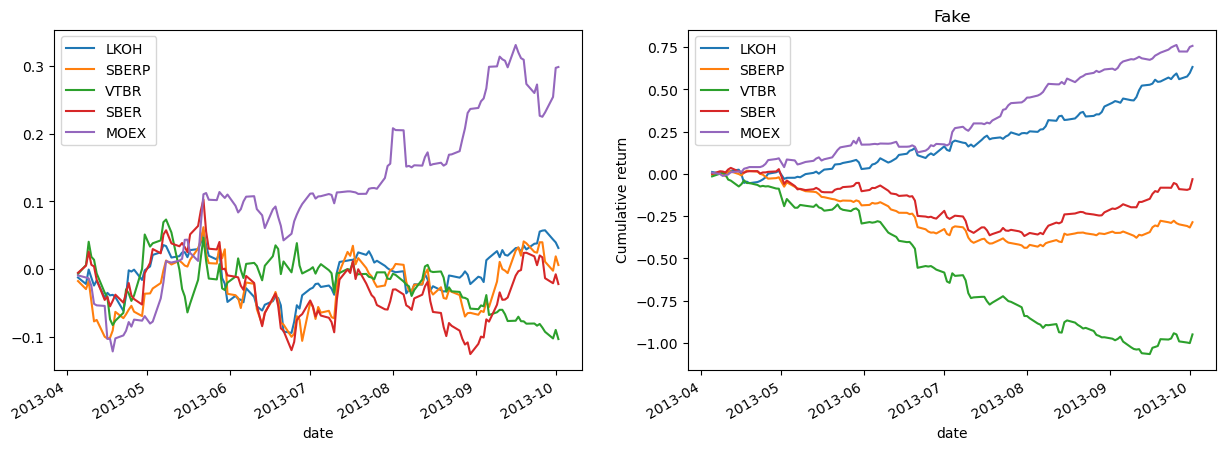

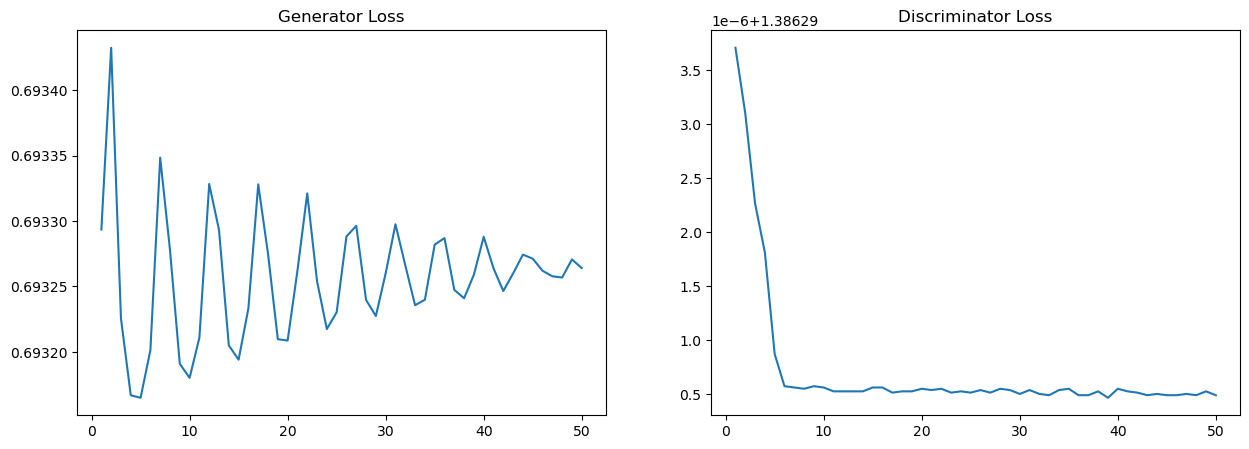

In [131]:
from gan_train_loop import train_gan

N_EPOCHS = 800
LOG_FREQUENCY = 50
SAVE_FREQUENCY = 200

# Define generator and discriminator
discriminator = Discriminator().to(DEVICE)
generator = Generator().to(DEVICE)

# Define the optimizers for generator and discriminator
LR = 0.0002
generator_optimizer = optim.RMSprop(generator.parameters(), lr=LR)
discriminator_optimizer = optim.RMSprop(discriminator.parameters(), lr=LR)

# Train GAN
discriminator_losses, generator_losses = train_gan(generator, discriminator, generator_optimizer, discriminator_optimizer, dataloader, df_returns_real, n_epochs=N_EPOCHS, log_frequency=LOG_FREQUENCY, save_frequency=SAVE_FREQUENCY, model_prefix='TCN')

# Generation

## Generate random history

In [132]:
from gan_train_loop import load_gan

generator = Generator().to(DEVICE)
load_gan('TCN', generator, epoch=800)

Load 800 epoch checkpoint


In [192]:
from generation import generate_fake_returns

df_returns_fake = generate_fake_returns(generator, df_returns_real, seed=0)

## Plot cumulative real and fake returns

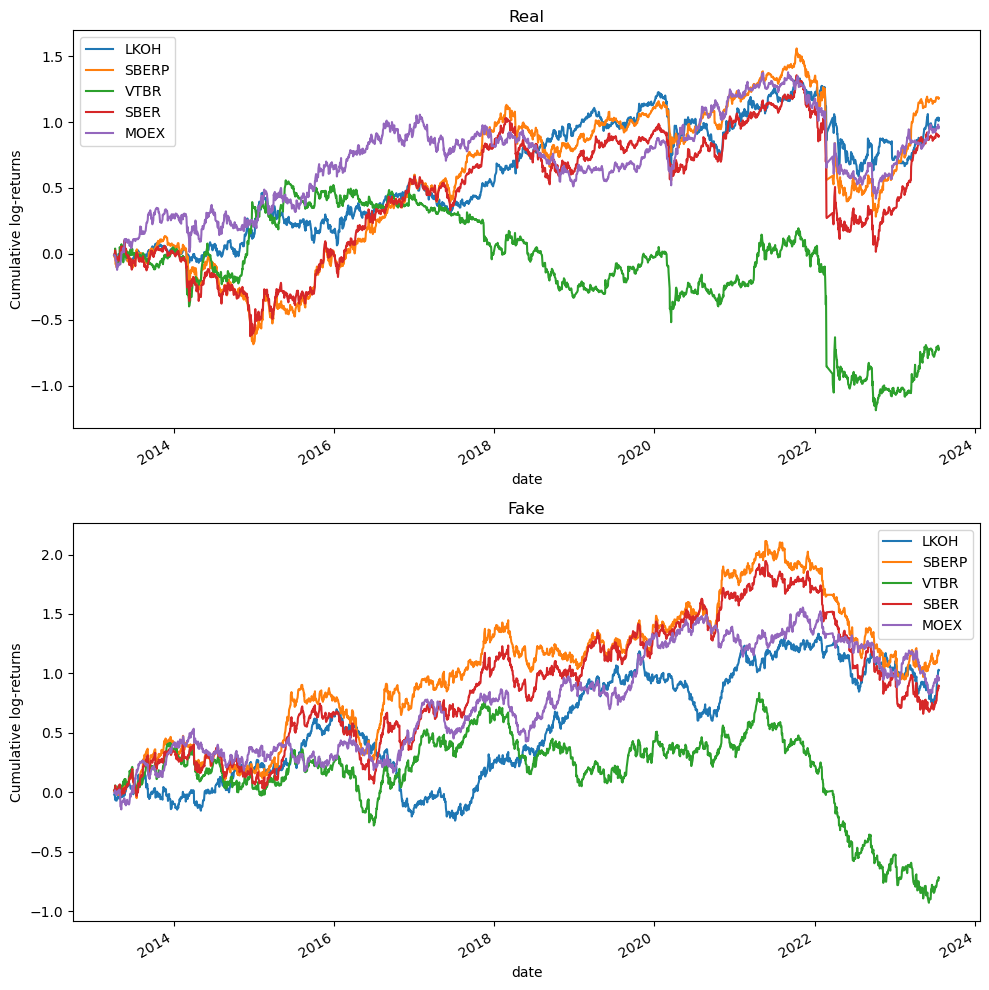

In [194]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

plt.subplot(2, 1, 1)

df_returns_real.cumsum().plot(ax=ax1)
plt.title('Real')
plt.ylabel('Cumulative log-returns')

plt.subplot(2, 1, 2)
df_returns_fake.cumsum().plot(ax=ax2)
plt.title('Fake')
plt.ylabel('Cumulative log-returns')
plt.tight_layout()

plt.show()

## Plot correlation matrix for real and fake returns

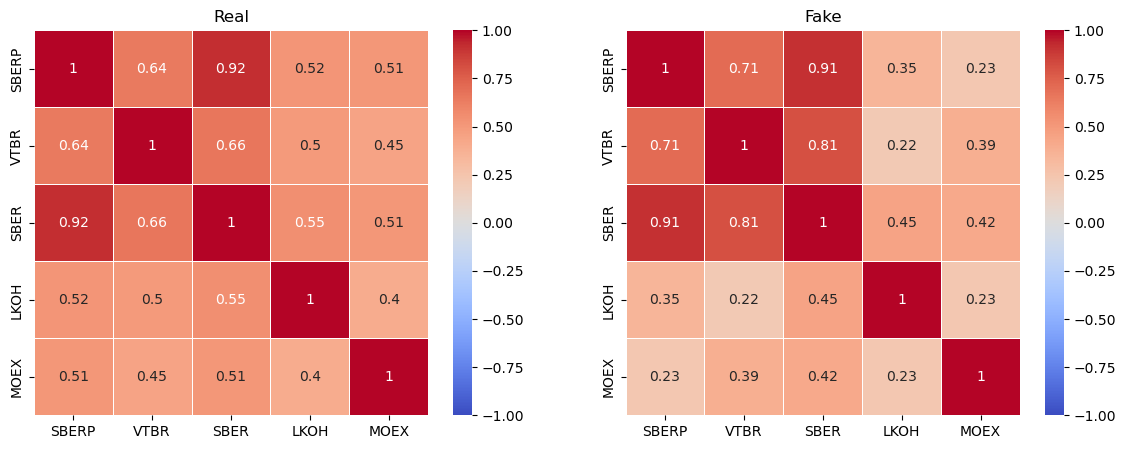

In [195]:
from correlations import plot_correlation_matrix

plt.subplots(1, 2, figsize=(14, 5))

plt.subplot(1, 2, 1)
plot_correlation_matrix(df_returns_real.corr())
plt.title('Real')

plt.subplot(1, 2, 2)
plot_correlation_matrix(df_returns_fake.corr())
plt.title('Fake')

plt.show()

# Plot returns distribution

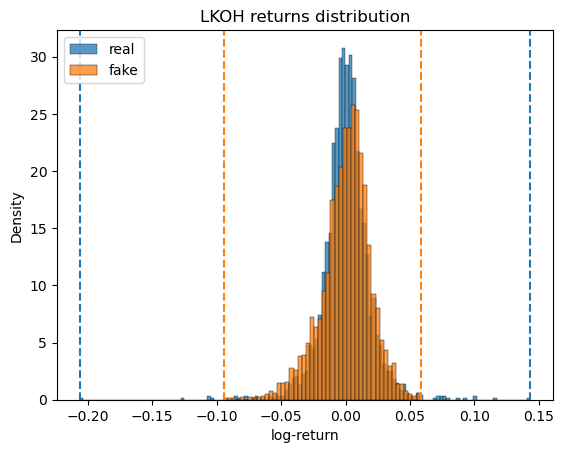

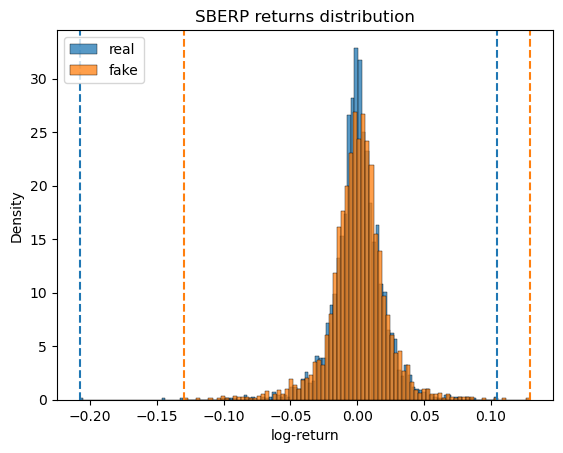

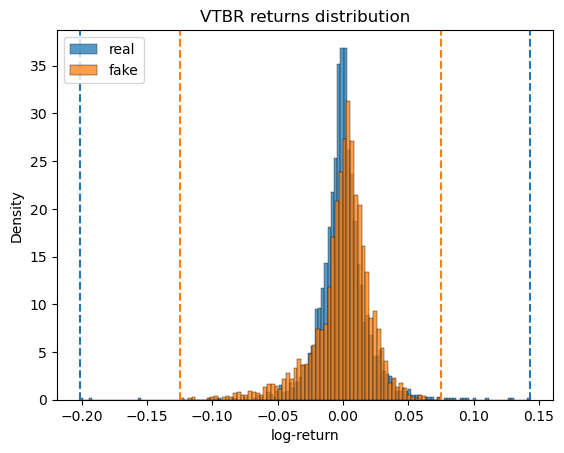

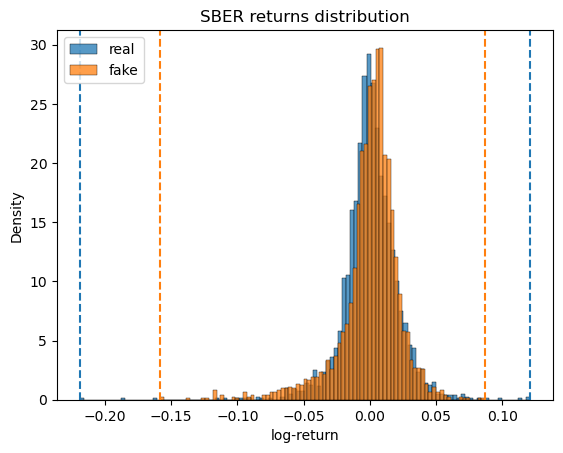

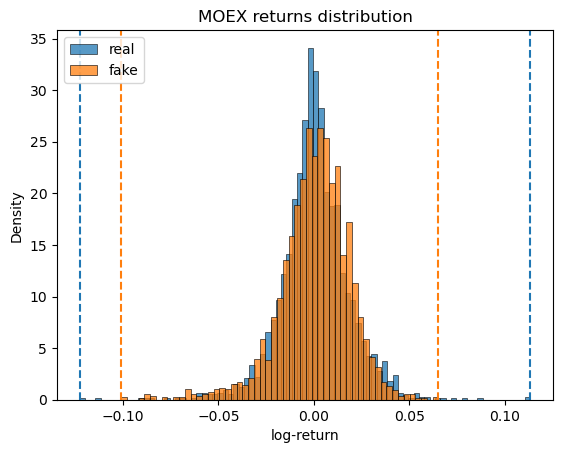

In [185]:
tmp_df_returns_real = df_returns_real[df_returns_real.sum(axis=1) != df_returns_real.sum(axis=1).min()]

for col in df_returns_real.columns:
    # Plot returns distributions
    sns.histplot(tmp_df_returns_real[col], stat='density', label='real')
    sns.histplot(df_returns_fake[col], stat='density', label='fake')

    # Plot real returns bounds
    plt.axvline(tmp_df_returns_real[col].min(), linestyle='dashed', color='C0')
    plt.axvline(tmp_df_returns_real[col].max(), linestyle='dashed', color='C0')

    # Plot fake returns bounds
    plt.axvline(df_returns_fake[col].min(), linestyle='dashed', color='C1')
    plt.axvline(df_returns_fake[col].max(), linestyle='dashed', color='C1')

    plt.xlabel('log-return')
    plt.legend(loc='upper left')
    plt.title(f'{col} returns distribution')
    plt.show()